<a href="https://colab.research.google.com/github/Kathy42xu/DL_TA/blob/main/diffusion_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
In this project, we explore diffusion models, a key generative AI technique. Diffusion models iteratively refine noisy data into meaningful patterns, offering a unique way to generate high-quality outputs. They are based on two main processes:

1. Forward Diffusion (Noising): Gradually adds Gaussian noise to data over multiple steps.
2. Reverse Diffusion (Denoising): Trains a neural network to iteratively remove noise and reconstruct the original data.


This project demonstrates these concepts using a scatter plot resembling Homer Simpson as an example.

##Key Objectives:

1. Understand the forward and reverse processes.
2. Learn how hyperparameters influence the diffusion process.
3. Visualize the denoising process and evaluate the results.

#Step 1: Importing Libraries
We first import the necessary libraries for tensor computation, visualization, and neural network training.

In [1]:
# Import required libraries
import torch  # PyTorch for tensor operations and neural networks
import numpy as np  # For numerical operations
import seaborn as sns  # Visualization library
import matplotlib.pyplot as plt  # For creating plots
from tqdm import tqdm  # Progress bar for iterative processes
from PIL import Image  # For image processing


Set up the computation device (GPU or CPU):

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#Step 2: Data Preparation and Visualization
The dataset for this project is a scatter plot based on an image of Homer Simpson.

Download this image https://www.infomoney.com.br/wp-content/uploads/2019/06/homer-simpson.jpg?resize=900%2C515&quality=50&strip=all and save it in this folder as 'homer.png'


We preprocess the image by converting it to grayscale, resizing it, and extracting the coordinates of pixels below a certain intensity threshold. These coordinates form the scatter plot.

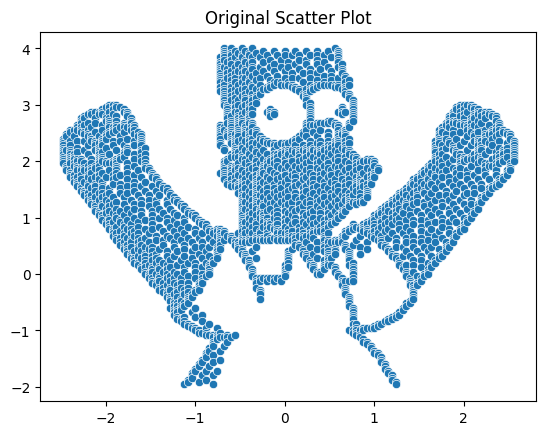

In [3]:
# Function to scatter pixels from an image
import string
from PIL import Image

IMG_SIZE = 150
def scatter_pixels(img_file):
    """Return the URL of a scatter plot of the supplied image

    The image will be rendered square and black on white. Adapt the
    code if you want something else.
    """
    # Use simple chart encoding. To make things really simple
    # use a square image where each X or Y position corresponds
    # to a single encode value.
    w = IMG_SIZE
    img = Image.open(img_file).resize((w, w)).convert("1")
    pels = img.load()
    black_pels = [(x, y) for x in range(w) for y in range(w)
                  if pels[x, y] == 0]
    sqside = 3.0

    # invert Y coordinate with w-y
    return [t[0] for t in black_pels],[w - t[1] for t in black_pels]

# Generate scatter data from the image
x, y = scatter_pixels('homer.png')
x = [x / 25 - 3 for x in x]  # Normalize x-coordinates
y = [y / 25 - 2 for y in y]  # Normalize y-coordinates

# Visualize the original scatter plot
sns.scatterplot(x=x, y=y)
plt.title("Original Scatter Plot")
plt.show()


Prepare data for diffusion


In [4]:
def pack_data(x,y):
    """
    pack 2d data to 1d vector
    """
    one_d_data = []
    for i in range(len(x)):
        one_d_data.append(x[i])
        one_d_data.append(y[i])

    return one_d_data

def unpack_1d_data(one_d_data):
    """
    unpack 1d data to 2d vector
    """
    x = []
    y = []
    for i in range(len(one_d_data)):
        if i%2==0:
            x.append(one_d_data[i])
        else:
            y.append(one_d_data[i])
    return x,y

one_d_data = pack_data(x,y)
x_init = torch.tensor(one_d_data).to(torch.float32).to(device)

DATA_SIZE = len(x_init)

#Step 3: Diffusion Hyperparameters
Hyperparameters control the noise schedule and the diffusion process:

**beta_start** and **beta_end**: Define the initial and final noise levels.

**num_diffusion_timesteps**: The number of steps in the diffusion process.

**alphas** and **list_bar_alphas**: Control the signal and noise retention.

In [5]:
# Hyperparameters for diffusion
DATA_SIZE = len(x)  # Total number of data points
beta_start = 0.0004  # Starting noise level
beta_end = 0.02  # Ending noise level
num_diffusion_timesteps = 30  # Number of timesteps

# Compute betas and alphas
betas = np.linspace(beta_start**0.5, beta_end**0.5, num_diffusion_timesteps) ** 2
alphas = 1 - betas
list_bar_alphas = np.cumprod(alphas)  # Cumulative product of alphas

# Convert to PyTorch tensors
betas = torch.tensor(betas, dtype=torch.float32).to(device)
alphas = torch.tensor(alphas, dtype=torch.float32).to(device)
list_bar_alphas = torch.tensor(list_bar_alphas, dtype=torch.float32).to(device)


#Step 4: Implementing Diffusion Functions

##Forward Diffusion
The forward process adds Gaussian noise to the data. This is done step-by-step, with each step parameterized by the cumulative alpha product.

In [6]:
def q_sample(x_start, t, list_bar_alphas, device):
    """
    Diffuse the data (t == 0 means diffused for 1 step)
    """
    alpha_bar_t = list_bar_alphas[t]

    mean = alpha_bar_t*x_start
    cov = torch.eye(x_start.shape[0]).to(device)
    cov = cov*(1-alpha_bar_t)
    return torch.distributions.MultivariateNormal(loc=mean,covariance_matrix=cov).sample().to(device)


##Reverse Denoising

The reverse process removes noise step-by-step to reconstruct the original data.

In [7]:
def denoise_with_mu(denoise_model, x_t, t, list_alpha, list_alpha_bar, DATA_SIZE, device):
    """
    Denoising function considering the denoising models tries to model the posterior mean
    """
    alpha_t = list_alpha[t]
    beta_t = 1 - alpha_t
    alpha_bar_t = list_alpha_bar[t]

    mu_theta = denoise_model(x_t,t)

    x_t_before = torch.distributions.MultivariateNormal(loc=mu_theta,covariance_matrix=torch.diag(beta_t.repeat(DATA_SIZE))).sample().to(device)

    return x_t_before


In [8]:
def posterior_q(x_start, x_t, t, list_alpha, list_alpha_bar, device):
    """
    calculate the parameters of the posterior distribution of q
    """
    beta_t = 1 - list_alpha[t]
    alpha_t = list_alpha[t]
    alpha_bar_t = list_alpha_bar[t]
    # alpha_bar_{t-1}
    alpha_bar_t_before = list_alpha_bar[t-1]

    # calculate mu_tilde
    first_term = x_start * torch.sqrt(alpha_bar_t_before) * beta_t / (1 - alpha_bar_t)
    second_term = x_t * torch.sqrt(alpha_t)*(1- alpha_bar_t_before)/ (1 - alpha_bar_t)
    mu_tilde = first_term + second_term

    # beta_t_tilde
    beta_t_tilde = beta_t*(1 - alpha_bar_t_before)/(1 - alpha_bar_t)

    cov = torch.eye(x_start.shape[0]).to(device)*(1-alpha_bar_t)

    return mu_tilde, cov

The position_encoding_init function creates a sinusoidal positional encoding table, which is often used in transformer-based models or models that require a representation of sequential or temporal information (like diffusion models). Positional encodings inject information about the position of data points into the model.

In [21]:
def position_encoding_init(n_position, d_pos_vec):
    """
    Initialize sinusoidal positional encodings.
    Args:
        n_position: Number of timesteps (num_diffusion_timesteps).
        d_pos_vec: Dimensionality of the positional encoding (matches len(x_init)).
    Returns:
        A PyTorch tensor of shape [n_position, d_pos_vec].
    """
    position_enc = np.array([
        [pos / np.power(10000, 2 * (i // 2) / d_pos_vec) for i in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)
    ])
    position_enc[:, 0::2] = np.sin(position_enc[:, 0::2])  # Apply sine to even indices
    position_enc[:, 1::2] = np.cos(position_enc[:, 1::2])  # Apply cosine to odd indices
    return torch.tensor(position_enc, dtype=torch.float32)


#Step 5: Building the Denoising Neural Network

The neural network predicts the mean of the reverse process distribution. Positional encodings are used to incorporate timestep information.


###The neural network comprises three fully connected layers:

1. Layer 1 (linear1): Combines the input data and positional encoding using a linear transformation.
2. Layer 2 (linear2): Applies a second linear transformation after a ReLU activation.
3. Layer 3 (linear3): Produces the final output, predicting the mean of the reverse process distribution.

In [25]:
class Denoising(torch.nn.Module):
    def __init__(self, x_dim, num_timesteps):
        """
        Initialize the denoising model.
        Args:
            x_dim: Dimensionality of input data (matches len(x_init)).
            num_timesteps: Number of timesteps in the diffusion process.
        """
        super(Denoising, self).__init__()
        self.linear1 = torch.nn.Linear(x_dim, x_dim)
        self.emb = position_encoding_init(num_timesteps, x_dim)  # Match len(x_init)
        self.linear2 = torch.nn.Linear(x_dim, x_dim)
        self.linear3 = torch.nn.Linear(x_dim, x_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x_input, t):
        """
        Forward pass for the denoising model.
        Args:
            x_input: Noisy input data (size matches len(x_init)).
            t: Current timestep.
        Returns:
            Predicted mean for the reverse process.
        """
        emb_t = self.emb[t]
        if x_input.shape != emb_t.shape:  # Ensure shapes match
            raise ValueError(f"Shape mismatch: x_input {x_input.shape}, emb_t {emb_t.shape}")
        x = self.relu(self.linear1(x_input + emb_t))
        x = self.relu(self.linear2(x))
        return self.linear3(x)



The network uses the ReLU (Rectified Linear Unit) activation function after the first two layers. ReLU introduces non-linearity, enabling the network to model complex relationships in the data.

The network outputs the predicted mean of the reverse Gaussian distribution for the given timestep. This predicted mean guides the denoising process.

#Step 6: Training the Model

We train the denoising model to minimize the error between the predicted mean and the true mean of the reverse process.

In [27]:
import torch.nn as nn
import torch.optim as optim


training_steps_per_epoch = 40


criterion = nn.MSELoss()
# Initialize the denoising model
denoising_model = Denoising(len(x_init), num_diffusion_timesteps).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(denoising_model.parameters(), lr=1e-3)

pbar = tqdm(range(10))
for epoch in pbar:
    running_loss = 0.0
    Ts = np.random.randint(1, num_diffusion_timesteps, size=training_steps_per_epoch)
    for _, t in enumerate(Ts):
        t_tensor = torch.tensor(t, dtype=torch.long)  # Ensure t is a tensor
        q_t = q_sample(x_init, t_tensor, list_bar_alphas, device)  # Generate noisy data
        emb_t = denoising_model.emb[t_tensor]  # Retrieve positional encoding



        mu_t, _ = posterior_q(x_init, q_t, t_tensor, alphas, list_bar_alphas, device)  # Posterior mean
        mu_theta = denoising_model(q_t, t_tensor)  # Predict mean
        loss = criterion(mu_theta, mu_t)  # Calculate loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    pbar.set_description(f'Epoch: {epoch + 1}, Loss: {running_loss / training_steps_per_epoch}')


  0%|          | 0/10 [00:00<?, ?it/s]

q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size(

Epoch: 1, Loss: 4.350482077151537:  10%|█         | 1/10 [04:10<37:37, 250.81s/it]

q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size(

Epoch: 2, Loss: 0.08098905524238945:  20%|██        | 2/10 [08:18<33:09, 248.72s/it]

q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size(

Epoch: 3, Loss: 0.08349091704003513:  30%|███       | 3/10 [12:22<28:48, 246.89s/it]

q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size(

Epoch: 4, Loss: 0.0690438415389508:  40%|████      | 4/10 [16:28<24:37, 246.26s/it]

q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size(

Epoch: 5, Loss: 0.07056884004268796:  50%|█████     | 5/10 [20:43<20:48, 249.69s/it]

q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size(

Epoch: 6, Loss: 0.07147714474704117:  60%|██████    | 6/10 [24:58<16:45, 251.32s/it]

q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size(

Epoch: 7, Loss: 0.08103580381721258:  70%|███████   | 7/10 [29:19<12:43, 254.44s/it]

q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size(

Epoch: 8, Loss: 0.0730416669510305:  80%|████████  | 8/10 [33:33<08:28, 254.33s/it]

q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size(

Epoch: 9, Loss: 0.08557938926387579:  90%|█████████ | 9/10 [37:57<04:17, 257.35s/it]

q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size([5134])
q_t shape: torch.Size([5134]), emb_t shape: torch.Size(

Epoch: 10, Loss: 0.05909428757149726: 100%|██████████| 10/10 [42:22<00:00, 254.24s/it]


#Step 7: Visualizing the Results
After training, we visualize the reconstruction process and compare the final result with the original scatter plot.

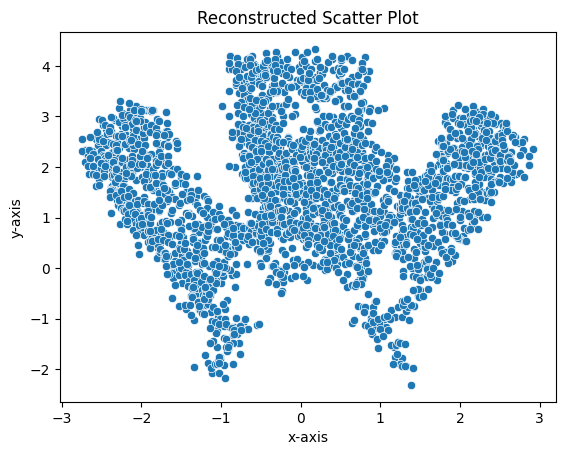

In [32]:
# Start with random noise
data = torch.distributions.MultivariateNormal(
    loc=torch.zeros(len(x_init)),  # Size matches x_init
    covariance_matrix=torch.eye(len(x_init))
).sample().to(device)

# Apply reverse diffusion process
for t in reversed(range(num_diffusion_timesteps)):
    data = denoise_with_mu(denoising_model, data, t, alphas, list_bar_alphas, len(x_init), device)

# Unpack the denoised data into x and y coordinates
data_np = data.cpu().detach().numpy()  # Move data to CPU and convert to NumPy
x_new, y_new = unpack_1d_data(data_np)  # Unpack the 1D data into 2D (x, y)

# Convert to NumPy arrays for compatibility with plotting
x_new = np.array(x_new, dtype=float)
y_new = np.array(y_new, dtype=float)

# Plot the reconstructed scatter plot
sns.scatterplot(x=x_new, y=y_new)
plt.title("Reconstructed Scatter Plot")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()


#Step 8: Animation of the Diffusion Process
To better understand the reverse diffusion process, we create an animation that visualizes the stepwise denoising.

In [36]:
!pip install celluloid

<ipython-input-42-82841507ebb1>:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.scatterplot(x=x_new, y=y_new, palette=['green'], s=10)


NameError: name 'axes' is not defined

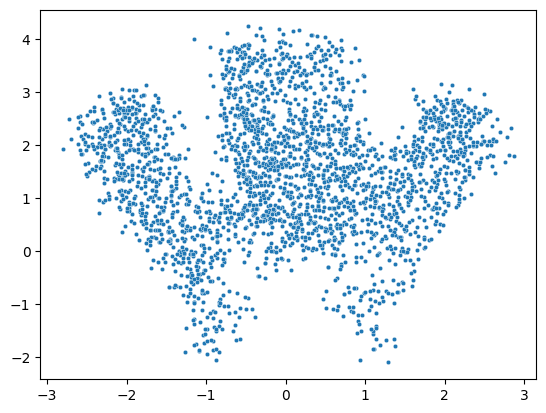

In [42]:
import numpy as np
from celluloid import Camera
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure for the animation
fig = plt.figure()
camera = Camera(fig)

# Reverse diffusion process and capture each timestep
for d in range(1, num_diffusion_timesteps + 1):
    # Perform reverse diffusion step
    data = denoise_with_mu(denoising_model, data, num_diffusion_timesteps - d, alphas, list_bar_alphas, len(x_init), device)

    # Extract and unpack the data into x and y coordinates
    data_plot = data.detach().cpu().numpy()
    x_new, y_new = unpack_1d_data(data_plot)

    # Plot the current state
    graph = sns.scatterplot(x=x_new, y=y_new, palette=['green'], s=10)
    graph.set_xlim(axes[0])  # Maintain consistent x-axis limits
    graph.set_ylim(axes[1])  # Maintain consistent y-axis limits
    plt.title(f"Reverse Diffusion Step: {d}")
    camera.snap()

# Create the animation
anim = camera.animate(blit=False)

# Save as a GIF
anim.save('output.gif', fps=24, dpi=120)


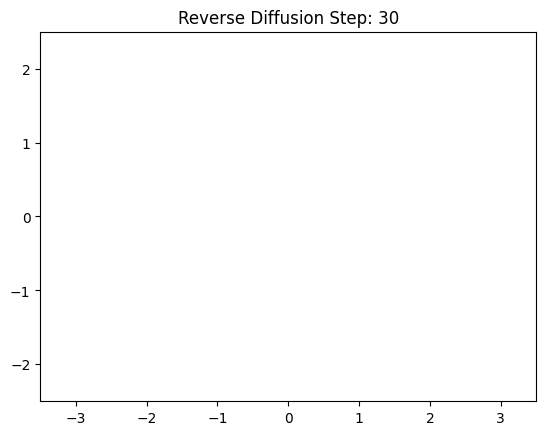

In [43]:
import numpy as np
from celluloid import Camera
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure for the animation
fig = plt.figure()
camera = Camera(fig)

# Set consistent x and y axis limits based on the original scatter plot
x_limits = (-3.5, 3.5)  # Adjust based on the normalized data range
y_limits = (-2.5, 2.5)

# Reverse diffusion process and capture each timestep
for d in range(1, num_diffusion_timesteps + 1):
    # Perform reverse diffusion step
    data = denoise_with_mu(denoising_model, data, num_diffusion_timesteps - d, alphas, list_bar_alphas, len(x_init), device)

    # Extract and unpack the data into x and y coordinates
    data_plot = data.detach().cpu().numpy()
    x_new, y_new = unpack_1d_data(data_plot)

    # Plot the current state
    graph = sns.scatterplot(x=x_new, y=y_new, color='green', s=10)  # Removed `palette` and set `color`
    graph.set_xlim(x_limits)  # Maintain consistent x-axis limits
    graph.set_ylim(y_limits)  # Maintain consistent y-axis limits
    plt.title(f"Reverse Diffusion Step: {d}")
    camera.snap()

# Create the animation
anim = camera.animate(blit=False)

# Save as a GIF
anim.save('output.gif', fps=24, dpi=120)


#Final Summary

This project provided a step-by-step guide to implementing a diffusion model for generating a scatter plot resembling Homer Simpson. Through the process, we explored:
 1. Forward Diffusion: A Markov process that progressively adds Gaussian noise to the data, turning it into near-pure noise over multiple steps.
 2. Reverse Diffusion: Using a neural network, we learned to iteratively remove noise and reconstruct the original data.
 3. Key Components: **Hyperparameters**: Controlled the noise schedule and the cumulative effects of noise and signal retention. **Neural Network**: Predicted the mean of the reverse distribution at each timestep using positional encodings.